In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, f1_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
ratings_df = pd.read_csv('./title.ratings.tsv.gz', delimiter="\t")

In [3]:
ratings_df= ratings_df.reset_index()




In [4]:
basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")

/Users/michelle/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
basics_df = basics_df.reset_index()

### Data Cleaning and Merging; Genre Handling #1


In [6]:
#filter only movies out
basics_movies_df =  basics_df[basics_df.titleType=="movie"]

#combine ratings and movie descriptions dataframes
basics_ratings_movie_df = basics_movies_df.merge(ratings_df, on='tconst', how='left')

#movies always have None for endYear
basics_ratings_movie_df=basics_ratings_movie_df.drop(columns="endYear")

#drop all null values/rows
basics_ratings_movie_df.replace(["\\N"],np.nan,inplace=True)
basics_ratings_movie_df=basics_ratings_movie_df.dropna( )

basics_ratings_movie_df=basics_ratings_movie_df.drop(columns=["titleType", "tconst"])

#preprocessing genres column (list of strings) using one-hot encoding
genres=basics_ratings_movie_df["genres"].apply(lambda x: x.split(',')).explode()
basics_ratings_movie_oh = pd.concat([basics_ratings_movie_df, pd.get_dummies(genres)], axis=1)

#group by primary title (unique)
basics_ratings_movie_oh = basics_ratings_movie_oh.groupby('primaryTitle').max().reset_index()

#turn each column to numeric
basics_ratings_movie_oh["startYear"] = pd.to_numeric(basics_ratings_movie_oh["startYear"])
basics_ratings_movie_oh["runtimeMinutes"] = pd.to_numeric(basics_ratings_movie_oh["runtimeMinutes"])

/var/folders/cq/z8p1mwgs5d79rzdqlq7zct7c0000gp/T/ipykernel_185/1376990445.py:21: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  basics_ratings_movie_oh = basics_ratings_movie_oh.groupby('primaryTitle').max().reset_index()


In [7]:
basics_ratings_movie_oh.iloc[3]

primaryTitle                            #5
index_x                            7242706
originalTitle                           #5
startYear                             2013
runtimeMinutes                          68
genres            Biography,Comedy,Fantasy
index_y                          1008943.0
averageRating                          4.8
numVotes                              17.0
Action                                   0
Adult                                    0
Adventure                                0
Animation                                0
Biography                                1
Comedy                                   1
Crime                                    0
Documentary                              0
Drama                                    0
Family                                   0
Fantasy                                  1
Film-Noir                                0
History                                  0
Horror                                   0
Music      

In [8]:
basics_ratings_movie_oh

,primaryTitle,index_x,originalTitle,startYear,runtimeMinutes,genres,index_y,averageRating,numVotes,Action,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,!Women Art Revolution,4546095,Women Art Revolution,2010,83,Documentary,775080.0,6.8,255.0,0,...,0,0,0,0,0,0,0,0,0,0
1,#1 Serial Killer,5932998,#1 Serial Killer,2013,87,Horror,916128.0,5.7,63.0,0,...,0,0,0,0,0,0,0,0,0,0
2,#1915House,1515213,#1915House,2018,55,"Horror,Thriller",507527.0,3.4,15.0,0,...,0,0,0,0,0,0,0,1,0,0
3,#5,7242706,#5,2013,68,"Biography,Comedy,Fantasy",1008943.0,4.8,17.0,0,...,0,0,0,0,0,0,0,0,0,0
4,#50Fathers,7834196,#50Fathers,2015,132,Comedy,1097096.0,4.3,11.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235148,Üçlü Pürüz,6497576,Üçlü Pürüz,2023,105,Comedy,967163.0,4.7,232.0,0,...,0,0,0,0,0,0,0,0,0,0
235149,Üçünüzü de mihlarim,263372,Üçünüzü de mihlarim,1965,70,"Adventure,Drama",166379.0,5.9,36.0,0,...,0,0,0,0,0,0,0,0,0,0
235150,Þegiðu og syntu,2448620,Þegiðu og syntu,2020,72,Documentary,595246.0,9.4,14.0,0,...,0,0,0,0,0,0,0,0,0,0
235151,à propos: philosophie,8162963,à propos: philosophie,2016,80,Documentary,1141700.0,8.5,8.0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = basics_ratings_movie_oh.drop(columns=["averageRating", "numVotes", "genres", "primaryTitle", "originalTitle", "index_y","index_x"])
y = basics_ratings_movie_oh["averageRating"]

In [10]:
X

,startYear,runtimeMinutes,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,2010,83,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2013,87,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2013,68,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,132,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235148,2023,105,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
235149,1965,70,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
235150,2020,72,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
235151,2016,80,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Train Test Split

In [11]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=42, test_size=0.25)

## Normal XGB Regressor

In [48]:
import time
xgb = XGBRegressor()

start = time.time()
xgb.fit(X_dev, y_dev)
stop = time.time()
print(f"Training time: {stop - start}s")

xgb_y_predict = xgb.predict(X_test)
  
print("mse base model: ",mean_squared_error(y_test,xgb_y_predict))
print("r2 base model: ",r2_score(y_test,xgb_y_predict))

Training time: 3.0649642944335938s
mse base model:  1.3066855363664056
r2 base model:  0.2791387447333883


In [13]:
#feature importances for normal XGB Regressor
feature_names = X_dev.columns
feature_imps = zip(feature_names, xgb.feature_importances_)
feature_imps=sorted(list(feature_imps), key=lambda x: x[1], reverse=True)
feature_imps

[('Documentary', 0.54159784),
 ('Drama', 0.106980495),
 ('Horror', 0.08310876),
 ('Animation', 0.030699996),
 ('Music', 0.018940913),
 ('Film-Noir', 0.018609848),
 ('Action', 0.015193384),
 ('Comedy', 0.014820483),
 ('Adult', 0.014179916),
 ('runtimeMinutes', 0.014116204),
 ('Sci-Fi', 0.013536454),
 ('Biography', 0.0122816395),
 ('Family', 0.01089817),
 ('startYear', 0.010682318),
 ('Thriller', 0.010356297),
 ('Crime', 0.009643007),
 ('Mystery', 0.00929135),
 ('History', 0.008566439),
 ('Romance', 0.008229738),
 ('Musical', 0.0070387716),
 ('Fantasy', 0.007034747),
 ('War', 0.0065453313),
 ('Western', 0.006009533),
 ('Adventure', 0.005728814),
 ('Reality-TV', 0.00515453),
 ('Sport', 0.0048591583),
 ('Talk-Show', 0.0030576226),
 ('News', 0.0028382319)]

## Hyperparameter Tuning

In [44]:
xgb = XGBRegressor()

In [15]:
from sklearn.model_selection import GridSearchCV


In [45]:
hyper_params = {"learning_rate": [0.01, 0.1, 0.3, 1], "max_depth": [3, 6, 9, 12],"booster": ["gbtree"], "subsample":[0.5, 0.75, 1]}
tree_xgb_grid = GridSearchCV(xgb, hyper_params, cv=5, n_jobs=-1, verbose=1,scoring="neg_mean_squared_error")

In [46]:
import time

start = time.time()
tree_xgb_grid.fit(X_dev, y_dev)
stop = time.time()
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Training time: 548.6085739135742s


In [47]:
best_params = tree_xgb_grid.best_params_
best_params

{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 0.75}

## XGB With Best Params

In [49]:
best_xgb = XGBRegressor(learning_rate=best_params["learning_rate"], max_depth=best_params["max_depth"], subsample=best_params["subsample"])
start = time.time()

best_xgb.fit(X_dev, y_dev)
stop = time.time()
print(f"Training time: {stop - start}s")


Training time: 2.8962960243225098s


In [20]:
f_importance = best_xgb.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')

<AxesSubplot:title={'center':'Feature Importance for XGBoost Regression Model'}, xlabel='Feature', ylabel='Importance'>

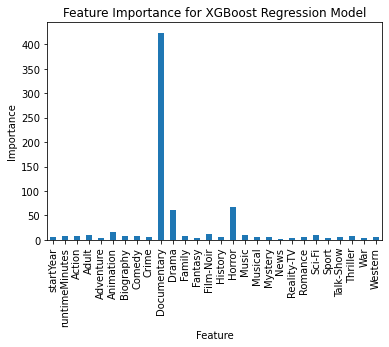

In [21]:
importance_df.plot.bar(legend=False, ylabel="Importance",xlabel="Feature",
                    title="Feature Importance for XGBoost Regression Model")


In [22]:
best_xgb_y_predict = best_xgb.predict(X_test)
  
mean_squared_error(y_test,best_xgb_y_predict)

1.3039147650288285

In [24]:
r2_score(y_test, best_xgb_y_predict)

0.2806673004944147

Text(0, 0.5, 'Prediction')

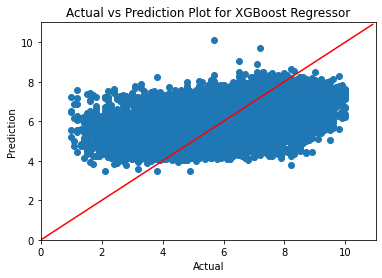

In [41]:
plt.scatter(y_test,best_xgb_y_predict)
plt.plot(np.arange(0,11,0.1), np.arange(0,11,0.1), color="r")
ax = plt.gca()
ax.set_xlim([0, 11])
ax.set_ylim([0, 11])
plt.title("Actual vs Prediction Plot for XGBoost Regressor")
plt.xlabel("Actual")
plt.ylabel("Prediction")

In [35]:
import seaborn as sns

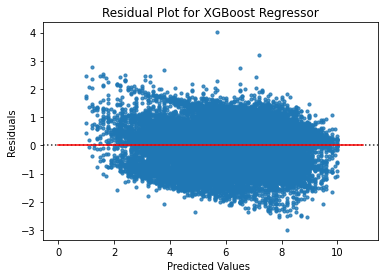

In [42]:
sns.residplot(x=y_test, y=best_xgb_y_predict, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.plot(np.arange(0,11,0.1), np.zeros(110), color="r")
plt.xlabel('Predicted Values ')
plt.ylabel('Residuals')
plt.title('Residual Plot for XGBoost Regressor')
plt.show()

# Miscelleneous

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
train_predict = lr.predict(X_train)
val_predict = lr.predict(X_val)
test_predict = lr.predict(X_test)

In [ ]:
train_mse = mean_squared_error(y_train, train_predict)
val_mse = mean_squared_error(y_val, val_predict)
test_mse = mean_squared_error(y_test, test_predict)
print("MSE for training data",train_r2)
print("MSE for validation data",val_r2)
print("MSE for Test data",test_r2)

In [ ]:
barWidth = 0.50
fig = plt.subplots(figsize =(15, 10))
 
plt.bar(list(X.columns), lr.coef_, color ='r', width = barWidth,
        edgecolor ='grey', label ='Weight')

plt.title('Model Weights after Linear Regression', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Model Weight', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X.columns))],
        list(X.columns), rotation ='vertical')
 
plt.legend()
plt.show()

In [ ]:
#need hyperparameter tuning
dr = DecisionTreeRegressor()
dr.fit(X_dev, y_dev)
dr_y_predict = dr.predict(X_test)
  
mean_squared_error(y_test,dr_y_predict)

In [38]:
dr_y_dev_predict= dr.predict(X_dev)
mean_squared_error(y_dev,dr_y_dev_predict)

0.5249689401887981

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)


In [ ]:
mean_squared_error(y_test,rf_y_predict)

In [ ]:
feature_names = X_dev.columns
feature_imps = zip(feature_names, rf.feature_importances_)
feature_imps=sorted(list(feature_imps), key=lambda x: x[1], reverse=True)
feature_imps